In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(50)

cv2.destroyAllWindows()

Text(0.5,1,'Undistorted Image')

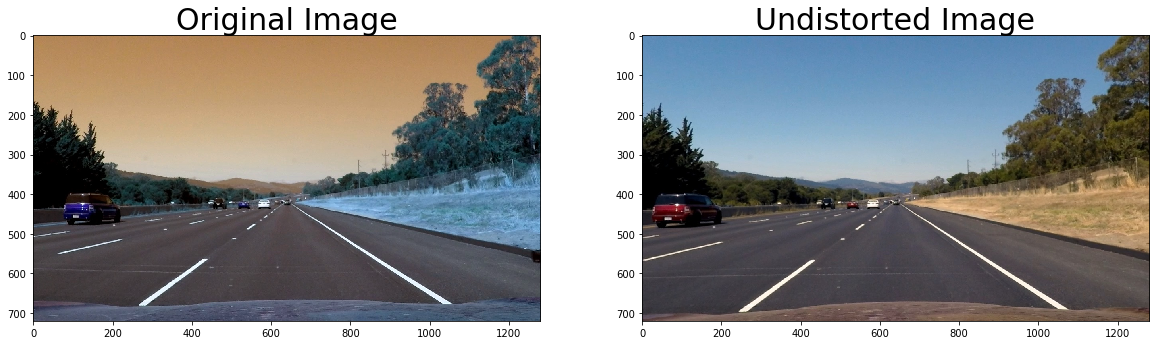

In [39]:
import pickle

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img = cv2.imread('test_images/straight_lines2.jpg')
img_size = (img.shape[1], img.shape[0])


# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


dst = cv2.undistort(img, mtx, dist, None, mtx)


# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
cv2.imwrite('test_undist.jpg', dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [15]:
img = cv2.imread('test_undist.jpg')

cv2.imshow('img', img)
cv2.waitKey(50000)
cv2.destroyAllWindows()

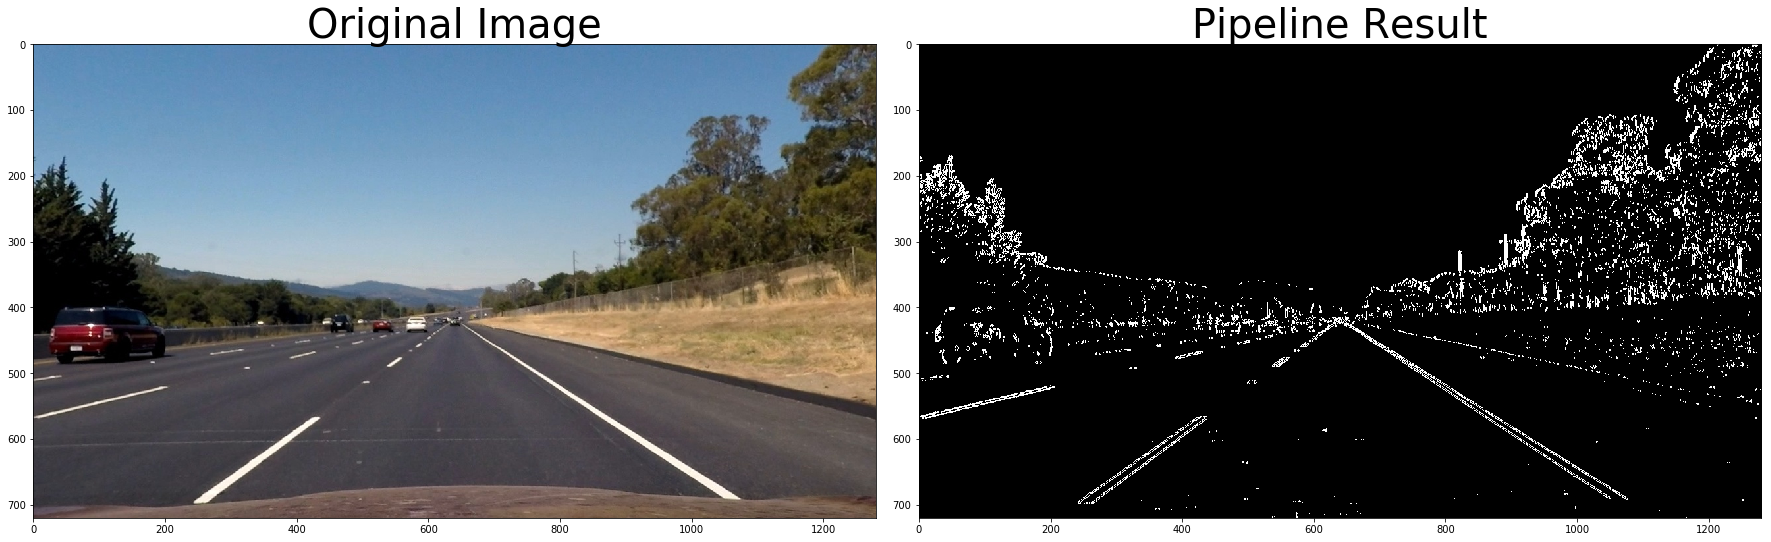

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = cv2.imread('test_undist.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, np.zeros_like(sxbinary))) * 255
    return color_binary, sxbinary
    
color_binary, sxbinary = pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(sxbinary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

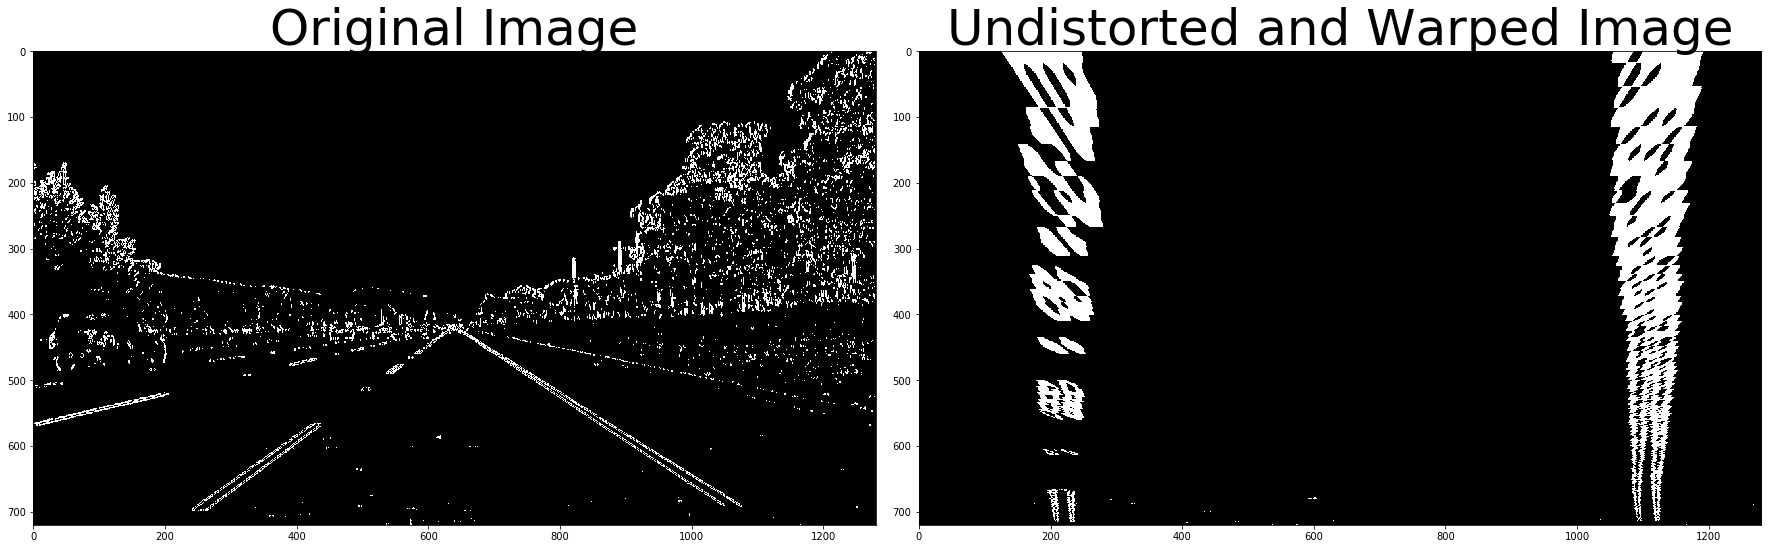

In [43]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open("wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
# img = cv2.imread('test_undist.jpg')
img = sxbinary
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # img = cv2.undistort(img, mtx, dist, None, mtx)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    src = np.float32([
        [609, 441],
        [674, 441],
        [1099, 719],
        [238, 719]
    ])
    
    dst = np.float32([
        [238, 100],
        [1099, 100],
        [1099, 719],
        [238, 719]
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    return warped, M

top_down, perspective_M = corners_unwarp(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

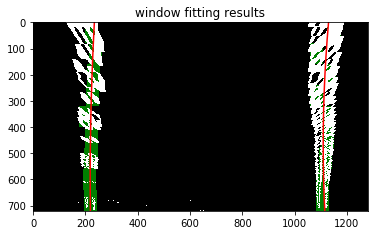

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
# warped = mpimg.imread('warped_example.jpg')
warped = top_down
# window settings
window_width =  50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100       # How much to slide left and right for searching

# return mask around (center, (level+0.5) * height) with size (width, height)
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)



# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

################## polyfit ################

l_points = np.array([])
r_points = np.array([])
h_points = np.array([])

for p in window_centroids:
    l_points = np.append(l_points, p[0])
    r_points = np.append(r_points, p[1])

for level in range(0,len(window_centroids)):
    h_points = np.append(h_points, warped.shape[0]-(level+0.5)*window_height)

# print(l_points, r_points, h_points)

# Fit a second order polynomial to each
left_fit = np.polyfit(h_points, l_points, 2)
right_fit = np.polyfit(h_points, r_points, 2)

ploty = np.linspace(
    start=0, 
    stop=warped.shape[0]-1, 
    num=warped.shape[0])

left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)    
    
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import pickle

src = np.float32([
    [609, 441],
    [674, 441],
    [1099, 719],
    [238, 719]
])

dst = np.float32([
    [238, 100],
    [1099, 100],
    [1099, 719],
    [238, 719]
])

dist_pickle = pickle.load( open("wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def pipe_distort2undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, np.zeros_like(sxbinary))) * 255
    return color_binary, sxbinary

def pipe_undistort2edges(img_undistort):
    color_binary, sxbinary = pipeline(img_undistort, s_thresh=(170, 255), sx_thresh=(20, 100))
    return sxbinary

def pipe_edges2warped(img_edges, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img_edges, M, (img_edges.shape[1], img_edges.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

# return mask around (center, (level+0.5) * height) with size (width, height)
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output


def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

def pipe_warped2data(warped):
    window_width =  50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100       # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    ################## polyfit ################

    l_points = np.array([])
    r_points = np.array([])
    h_points = np.array([])

    for p in window_centroids:
        l_points = np.append(l_points, p[0])
        r_points = np.append(r_points, p[1])

    for level in range(0,len(window_centroids)):
        h_points = np.append(h_points, warped.shape[0]-(level+0.5)*window_height)

    # print(l_points, r_points, h_points)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(h_points, l_points, 2)
    right_fit = np.polyfit(h_points, r_points, 2)

    ploty = np.linspace(
        start=0, 
        stop=warped.shape[0]-1, 
        num=warped.shape[0])

    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

def pipe_warped2origin(warped, undist, ploty, left_fitx, right_fitx, src, dst):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst, src)

    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 

    # Combine the result with the original image
    undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

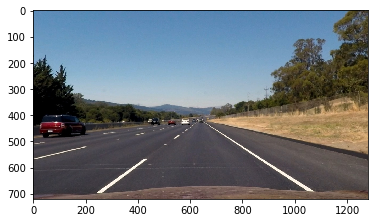

In [20]:
img = cv2.imread('test_images/straight_lines2.jpg')

undist = pipe_distort2undistort(img)
sxbinary = pipe_undistort2edges(undist)
warped = pipe_edges2warped(sxbinary, src, dst)

plt.imshow(undist)

ploty, left_fitx, right_fitx = pipe_warped2data(warped)

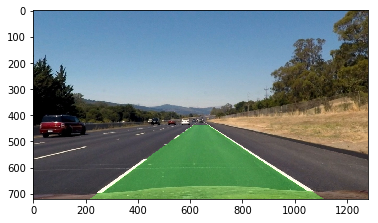

In [22]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
src = np.float32([
    [609, 441],
    [674, 441],
    [1099, 719],
    [238, 719]
])
    
dst = np.float32([
    [238, 100],
    [1099, 100],
    [1099, 719],
    [238, 719]
])
Minv = cv2.getPerspectiveTransform(dst, src)

newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 

# Combine the result with the original image
undist = cv2.imread('test_undist.jpg')
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [37]:
def process_image(image):
    undist = pipe_distort2undistort(image)
    sxbinary = pipe_undistort2edges(undist)
    warped = pipe_edges2warped(sxbinary, src, dst)
    ploty, left_fitx, right_fitx = pipe_warped2data(warped)
    result = pipe_warped2origin(warped, undist, ploty, left_fitx, right_fitx, src, dst)
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    return result

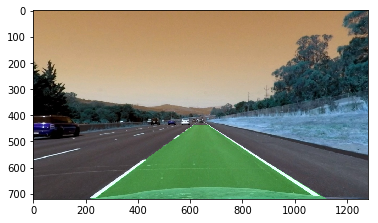

In [38]:
undist = plt.imread('test_undist.jpg')
plt.imshow(process_image(undist))

In [39]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:54<00:00, 10.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 1s, sys: 12.3 s, total: 2min 14s
Wall time: 1min 55s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))